In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d
import math
import matplotlib.style
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import opto_util as opto

import importlib
plt.rcParams.update({
    'font.sans-serif': 'arial',
    'font.family': 'sans-serif'
})

In [2]:
Penk_xls = pd.ExcelFile('PPR_sheets/Penk_PPRs.xlsx')
Rorb_xls = pd.ExcelFile('PPR_sheets/Rorb_PPRs.xlsx')
Tlx3_xls = pd.ExcelFile('PPR_sheets/Tlx3_PPRs.xlsx')
Sst_xls = pd.ExcelFile('PPR_sheets/Sst_PPRs.xlsx')
Pvalb_xls = pd.ExcelFile('PPR_sheets/Pvalb_PPRs.xlsx')

In [3]:
def PPR_cnx(cnx_df):
    cnx_df['trial_PPR']=cnx_df['DC2']/cnx_df['DC1']
    cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
    cnx_df['amp_norm']=cnx_df['peaks1']/np.mean(cnx_df['peaks1'][0:5])
    plt.scatter(cnx_df.trial_ISI, cnx_df.trial_PPR)
    plt.show()
    sub=cnx_df.dropna(subset=['trial_ISI'])
    ISI_hist=np.histogram(sub.trial_ISI)
    ISI_hist_peak=ISI_hist[1][np.argmax(ISI_hist[0])]##bin with most common ISI
    sub_cnx_df=sub[(sub.trial_ISI>(ISI_hist_peak-1.5)) & (sub.trial_ISI<(ISI_hist_peak+1.5))]
    plt.scatter(sub_cnx_df.trial_ISI, sub_cnx_df.trial_PPR)
    plt.scatter(np.mean(sub_cnx_df.trial_ISI), np.mean(sub_cnx_df.trial_PPR))
    plt.show()
    print "PPR:", np.mean(sub_cnx_df.trial_PPR), "ISI:", np.mean(sub_cnx_df.trial_ISI)
    return {'cnx_df':cnx_df}

In [3]:
def PPR_cnx_setISI(cnx_df):
    cnx_df=cnx_df.sort_values(by='sweeps').reset_index(drop=True)
    cnx_df['trial_PPR']=cnx_df['DC2']/cnx_df['DC1']
    cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
    cnx_df['amp_norm']=cnx_df['peaks1']/np.mean(cnx_df['peaks1'][0:5])
    #plt.scatter(cnx_df.trial_ISI, cnx_df.trial_PPR)
    #plt.xlabel('trial ISI')
    #plt.ylabel('trial PPR')
    #plt.show()
    cnx_df_3t7=cnx_df[(cnx_df['trial_ISI']>3) & (cnx_df['trial_ISI']<7)]
    cnx_df_7t13=cnx_df[(cnx_df['trial_ISI']>7) & (cnx_df['trial_ISI']<13)]
    cnx_df_5t10=cnx_df[(cnx_df['trial_ISI']>5) & (cnx_df['trial_ISI']<10)]
    if len(cnx_df_3t7.DC2)>4: ##if at least 5 trials in this window, save average
        PPR_3t7=np.mean(cnx_df_3t7.DC2)/np.mean(cnx_df.DC1)
    else:
        PPR_3t7=float('NaN')
    if len(cnx_df_7t13.DC2)>4: ##if at least 5 trials in this window, save average
        PPR_7t13=np.mean(cnx_df_7t13.DC2)/np.mean(cnx_df.DC1)
    else:  
        PPR_7t13=float('NaN')
    if len(cnx_df_5t10.DC2)>4: ##if at least 5 trials in this window, save average
        PPR_5t10=np.mean(cnx_df_5t10.DC2)/np.mean(cnx_df.DC1)
    else:  
        PPR_5t10=float('NaN')
    
    #print ("PPR 3-7 ms:", PPR_3t7)
    #print ("PPR 7-13 ms:", PPR_7t13)
    #print ("PPR 5-10 ms:", PPR_5t10)
    
    m, b = np.polyfit(cnx_df.index, cnx_df.peaks1, 1)
    
    
    return {'PPR_3t7':PPR_3t7, 'PPR_7t13':PPR_7t13,'PPR_5t10':PPR_5t10, 'm':m, 'b':b}
    #return {'cnx_df':cnx_df}

    

def PPR_all(cnx_df, name):
    DC1_mean=np.mean(cnx_df.DC1)
    cnx_df=cnx_df.dropna(subset=['DC2'])
    cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
    cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
    cnx_df=cnx_df.dropna(subset=['DC2'])
    #plt.scatter(cnx_df.trial_ISI,cnx_df.trial_PPR_avg)
    #plt.xlabel('ISI')
    #plt.ylabel('PPR')
    #plt.show()
    return {name:cnx_df}
    
def SMAQ(amps):  ##statistical moments analysis of quanta as described in Holler et al. 2021 Nature
    u=np.mean(amps)
    sig=np.std(amps)
    gamma=stats.skew(amps)
    trial_n=len(amps)
    N=-1*(u**2)/((gamma*u-sig)*sig)
    P=(gamma*u-sig)/(gamma*u-2*sig)
    Q=(-1*gamma*u*sig+2*sig**2)/u
    #print "N:", N, "P: ", P, "Q: ",Q 
    return {'N':N, 'P':P, 'Q':Q, 'u':u,'sig':sig,'gamma':gamma,'trial_n':trial_n}



In [4]:
def PDR_cnx_setISI(cnx_df): ##paired depolarization ratio, combined PSP amplitude/amplitude of 1st PSP, 
    cnx_df['trial_PDR']=cnx_df['peaks2']/cnx_df['peaks1']
    cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
    cnx_df['amp_norm']=cnx_df['peaks1']/np.mean(cnx_df['peaks1'][0:5])
    #plt.scatter(cnx_df.trial_ISI, cnx_df.trial_PDR)
    #plt.xlabel('trial ISI')
    #plt.ylabel('trial PDR')
    #plt.show()
    cnx_df_3t7=cnx_df[(cnx_df['trial_ISI']>3) & (cnx_df['trial_ISI']<7)]
    cnx_df_7t13=cnx_df[(cnx_df['trial_ISI']>7) & (cnx_df['trial_ISI']<13)]
    cnx_df_5t10=cnx_df[(cnx_df['trial_ISI']>5) & (cnx_df['trial_ISI']<10)]
    if len(cnx_df_3t7.peaks2)>4: ##if at least 5 trials in this window, save average
        PDR_3t7=np.mean(cnx_df_3t7.peaks2)/np.mean(cnx_df.peaks1)
    else:
        PDR_3t7=float('NaN')
    if len(cnx_df_7t13.peaks2)>4: ##if at least 5 trials in this window, save average
        PDR_7t13=np.mean(cnx_df_7t13.peaks2)/np.mean(cnx_df.peaks1)
    else:  
        PDR_7t13=float('NaN')
    if len(cnx_df_5t10.peaks2)>4: ##if at least 5 trials in this window, save average
        PDR_5t10=np.mean(cnx_df_5t10.peaks2)/np.mean(cnx_df.peaks1)
    else:  
        PDR_5t10=float('NaN')
    
    #print ("PDR 3-7 ms:", PDR_3t7)
    #print ("PDR 7-13 ms:", PDR_7t13)
    #print ("PDR 5-10 ms:", PDR_5t10)
    return {'PDR_3t7':PDR_3t7, 'PDR_7t13':PDR_7t13,'PDR_5t10':PDR_5t10}


In [5]:
def make_summary_df(xls):
    df_map = {}
    dict_of_dfs={}
    for sheet_name in xls.sheet_names:
        df_map[sheet_name] = xls.parse(sheet_name)

    cnx_dict_list=[]
    PPR_cnxs=df_map.keys()
    cnx_dict={}
    for cnx in PPR_cnxs:
        cnx_dict={'name':cnx}
        cnx_df=df_map[cnx]
        #print cnx
        PPR_vals=PPR_cnx_setISI(cnx_df)
        PDR_vals=PDR_cnx_setISI(cnx_df)
        cnx_dict.update(PPR_vals)
        cnx_dict.update(PDR_vals)
        #plt.hist(cnx_df.peaks1)
        #plt.xlabel('first peak')
        #plt.show()
        #plt.plot(cnx_df.peaks1, marker='o')
        #plt.ylabel('first peak')
        #plt.xlabel('sweep')
        #plt.show()
        out_cnxs=PPR_all(cnx_df,cnx)
        dict_of_dfs.update(out_cnxs)
        #print len(cnx_df.peaks1)
        SMAQ_dict=SMAQ(cnx_df.peaks1)
        cnx_dict.update(SMAQ_dict)
        cnx_dict_list.append(cnx_dict)

    summary_df=pd.DataFrame(cnx_dict_list)
    summary_df['exp_id']=summary_df.name.str[0:18]
    summary_df['MP_ID']='temp'
    summary_df['headstage']=0

    for i in summary_df.index:
        PS_name=str.split(str(summary_df.name[i]),'_')[5]
        if PS_name.startswith('T'):
            #print PS_name
            T_name_split=str.split(PS_name)
            T_round=T_name_split[0][1:]
            T_stim=T_name_split[1]
            full_name="TSeries_"+T_round+"_"+T_stim
            #print full_name
            summary_df['MP_ID'][i]=full_name
        else:
            summary_df['MP_ID'][i]='Point '+str.split(str(summary_df.name[i]),'_')[5]
        #print summary_df['MP_ID'][i]
        summary_df['headstage'][i]=int(summary_df.name[i][-1:])
    return summary_df, dict_of_dfs

In [6]:
full_df=pd.read_csv('20210415_full_df.csv')

/Users/travish/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,24,56) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
intKclusters=pd.read_csv('interneuron_Kclusters_1203.csv')
full_df = pd.merge(full_df, intKclusters,  how='left', left_on=['exp_id','headstage'], right_on = ['experiment','headstage'])
full_df.Kcluster.unique()

array([ 1., nan,  0.,  2.])

In [8]:
Penk_summary_df, Penk_cnx_dict=make_summary_df(Penk_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1432054757.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [9]:
Penk_summary_df

,name,PPR_3t7,PPR_7t13,PPR_5t10,m,b,PDR_3t7,PDR_7t13,PDR_5t10,N,P,Q,u,sig,gamma,trial_n,exp_id,MP_ID,headstage
0,2020_08_21_exp1_TH_38_AD1,1.833041,1.768586,1.836112,0.007135,0.256279,3.363080,2.840986,3.066409,-3.810801,-0.784209,0.108436,0.324057,0.250392,1.112292,20,2020_08_21_exp1_TH,Point 38,1
1,2020_08_21_exp1_TH_28_AD1,1.676419,1.038435,1.201345,0.000757,0.246673,3.022709,2.082588,2.518311,-31.338981,-0.030940,0.260645,0.252733,0.260599,1.062070,17,2020_08_21_exp1_TH,Point 28,1
2,2020_08_21_exp1_TH_27_AD3,1.764614,1.330705,1.619977,0.007069,1.362170,2.303102,2.117486,2.241230,17.681666,0.140741,0.574366,1.429329,0.839890,0.491364,20,2020_08_21_exp1_TH,Point 27,3
3,2020_08_21_exp1_TH_21_AD3,NaN,1.509063,1.774447,0.135427,2.858280,NaN,1.941761,2.167864,-3.178614,36.821549,-0.035413,4.144841,2.293032,1.121895,20,2020_08_21_exp1_TH,Point 21,3
4,2020_08_21_exp1_TH_18_AD3,1.363880,1.029911,1.200544,-0.114323,4.035414,1.996056,1.665407,1.860104,2.758735,0.551743,1.937663,2.949343,1.600535,-0.125284,20,2020_08_21_exp1_TH,Point 18,3
5,2020_11_12_exp2_TH_30_AD3,1.129129,0.971834,1.065129,-0.039190,6.033702,1.933110,1.815177,1.916167,5.099799,0.530371,2.020659,5.465448,2.277387,-0.053895,30,2020_11_12_exp2_TH,Point 30,3
6,2020_11_12_exp2_TH_29_AD3,NaN,0.490759,0.528757,0.015215,2.199350,NaN,1.263650,1.261480,2.096601,0.599204,2.089768,2.625359,1.482876,-0.279610,57,2020_11_12_exp2_TH,Point 29,3
7,2020_11_12_exp2_TH_13_AD3,0.739820,0.924256,0.933393,-0.001473,0.709457,2.092715,1.780562,2.546023,4.211445,0.149459,1.095525,0.689567,0.801580,0.958173,28,2020_11_12_exp2_TH,Point 13,3
8,2020_07_31_exp2_TH_13_AD0,1.251592,NaN,1.241207,0.001835,0.303110,2.180923,NaN,2.109761,-3.037466,-1.450236,0.076725,0.337976,0.252066,1.187239,39,2020_07_31_exp2_TH,Point 13,0
9,2020_07_30_exp2_TH_20_AD3,1.077948,0.849589,0.959494,0.000902,0.163437,2.115867,1.515167,2.022583,11.175577,0.102491,0.168670,0.193194,0.171016,0.784117,67,2020_07_30_exp2_TH,Point 20,3


In [13]:
Penk_master_isi=[]
Penk_master_PPR=[]
for key in Penk_cnx_dict:
    df=Penk_cnx_dict[key]
    df=df[df.trial_ISI>2]

    Penk_master_isi.extend(np.array(df.trial_ISI))
    Penk_master_PPR.extend(np.array(df.trial_PPR_avg))


Text(0, 0.5, 'PPR')

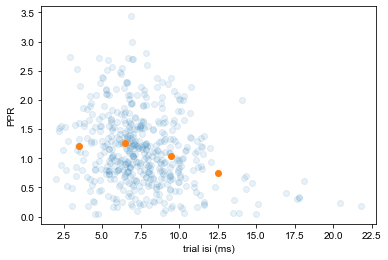

In [19]:
bins=np.arange(2,16,3)
plt.scatter(Penk_master_isi, Penk_master_PPR,alpha=0.1)
Penk_binned_mean=stats.binned_statistic(Penk_master_isi, Penk_master_PPR, bins=bins, statistic='mean')[0]
plt.scatter(opto.midPoints(bins), Penk_binned_mean)
plt.xlabel('trial isi (ms)')
plt.ylabel('PPR')

In [15]:
Rorb_summary_df, Rorb_cnx_dict=make_summary_df(Rorb_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1432054757.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [17]:
Rorb_summary_df

,N,P,PDR_3t7,PDR_5t10,PDR_7t13,PPR_3t7,PPR_5t10,PPR_7t13,Q,b,gamma,m,name,sig,trial_n,u,exp_id,MP_ID,headstage
0,2.444256,0.547067,1.982555,2.434908,2.221120,1.124910,1.191368,1.181041,0.156320,0.214159,-0.120960,-0.000263,2019_06_28_exp2_TH_18_AD1,0.121654,40,0.209027,2019_06_28_exp2_TH,Point 18,1
1,789.431239,0.004510,1.609979,1.662748,1.627227,1.087444,1.100681,1.028125,0.058669,0.272809,0.526358,-0.006727,2018_09_10_exp2_TH_T812 6_AD0,0.110457,20,0.208900,2018_09_10_exp2_TH,TSeries_812_6,0
2,16.277869,0.040925,3.101547,3.069749,NaN,2.043612,NaN,NaN,0.700353,0.231436,1.148666,0.012709,2019_05_29_exp2_TH_31_AD0,0.559805,38,0.466556,2019_05_29_exp2_TH,Point 31,0
3,4.041699,0.602203,NaN,NaN,1.927277,NaN,1.153313,1.214485,0.088780,0.175932,-0.207735,0.008923,2019_06_05_exp1_TH_40_AD1,0.087358,10,0.216085,2019_06_05_exp1_TH,Point 40,1
4,4.994581,0.604535,NaN,1.570118,1.532035,NaN,0.843611,0.832115,0.177786,0.695136,-0.191328,-0.016666,2019_06_05_exp1_TH_28_AD1,0.194273,20,0.536808,2019_06_05_exp1_TH,Point 28,1
5,4.571236,0.584886,1.367252,NaN,NaN,0.557347,0.323087,NaN,0.212636,0.673572,-0.161149,-0.015008,2019_07_09_exp2_TH_36_AD2,0.224013,15,0.568515,2019_07_09_exp2_TH,Point 36,2
6,2.010274,0.607852,1.854575,NaN,NaN,0.954785,NaN,NaN,0.383636,0.517628,-0.311607,-0.005141,2019_07_09_exp1_TH_36_AD2,0.265565,20,0.468784,2019_07_09_exp1_TH,Point 36,2
7,6.190513,0.649059,1.267479,NaN,NaN,0.506091,NaN,NaN,0.121876,0.460452,-0.251053,0.002017,2018_04_06_exp3_TH_T632 2_AD1,0.144724,30,0.489698,2018_04_06_exp3_TH,TSeries_632_2,1
8,8.614703,0.546577,1.520700,1.430714,NaN,0.762679,0.669267,0.467642,0.077290,0.501823,-0.063754,-0.014515,2020_06_04_exp3_TH_4_AD2,0.112933,20,0.363929,2020_06_04_exp3_TH,Point 4,2
9,4.657180,0.375957,1.198785,1.870594,1.727917,NaN,0.843340,0.865777,0.279692,0.482405,0.237336,0.000375,2020_06_04_exp2_TH_14_AD3,0.292360,40,0.489713,2020_06_04_exp2_TH,Point 14,3


In [18]:
Rorb_master_isi=[]
Rorb_master_PPR=[]
for key in Rorb_cnx_dict:
    df=Rorb_cnx_dict[key]
    df=df[df.trial_ISI>2]

    Rorb_master_isi.extend(np.array(df.trial_ISI))
    Rorb_master_PPR.extend(np.array(df.trial_PPR_avg))


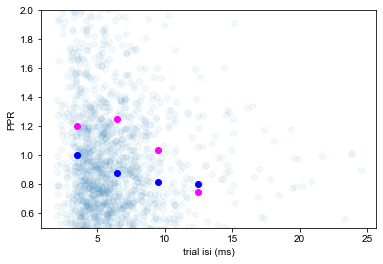

In [20]:
#bins=np.arange(2,25,2)
plt.scatter(Rorb_master_isi, Rorb_master_PPR,alpha=0.051)
Rorb_binned_mean=stats.binned_statistic(Rorb_master_isi, Rorb_master_PPR, bins=bins, statistic='mean')[0]
plt.scatter(opto.midPoints(bins), Rorb_binned_mean,c='blue')
plt.scatter(opto.midPoints(bins), Penk_binned_mean,c='magenta')
plt.ylim([0.5,2])
plt.xlabel('trial isi (ms)')
plt.ylabel('PPR')
plt.show()

In [21]:
Tlx3_summary_df, Tlx3_cnx_dict=make_summary_df(Tlx3_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1432054757.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [23]:
Tlx3_master_isi=[]
Tlx3_master_PPR=[]
for key in Tlx3_cnx_dict:
    df=Tlx3_cnx_dict[key]
    df=df[df.trial_ISI>2]
    Tlx3_master_isi.extend(np.array(df.trial_ISI))
    Tlx3_master_PPR.extend(np.array(df.trial_PPR_avg))

plt.show()

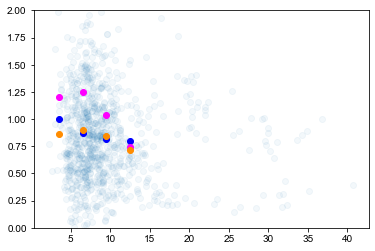

In [24]:
#bins=np.arange(2,25,2)
plt.scatter(Tlx3_master_isi, Tlx3_master_PPR,alpha=0.051)
Tlx3_binned_mean=stats.binned_statistic(Tlx3_master_isi, Tlx3_master_PPR, bins=bins, statistic='mean')[0]
plt.scatter(opto.midPoints(bins), Rorb_binned_mean,c='blue')
plt.scatter(opto.midPoints(bins), Penk_binned_mean,c='magenta')
plt.scatter(opto.midPoints(bins), Tlx3_binned_mean,c='darkorange')

plt.ylim([0,2])
plt.show()

In [26]:
Pvalb_summary_df,Pvalb_cnx_dict=make_summary_df(Pvalb_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1432054757.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [27]:
Sst_summary_df,Sst_cnx_dict=make_summary_df(Sst_xls)

/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_ISI']=cnx_df['DC2_t']-cnx_df['DC1_t']
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1656287825.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnx_df['trial_PPR_avg']=cnx_df['DC2']/DC1_mean
/var/folders/r_/1r34q4315614mp9bkdvjcjph0000gp/T/ipykernel_64359/1432054757.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [28]:
full_ppr_df=pd.concat([Penk_summary_df, Rorb_summary_df, Tlx3_summary_df, Pvalb_summary_df, Sst_summary_df])
print (np.shape(full_ppr_df))

(257, 19)


In [29]:
full_ppr_df

,name,PPR_3t7,PPR_7t13,PPR_5t10,m,b,PDR_3t7,PDR_7t13,PDR_5t10,N,P,Q,u,sig,gamma,trial_n,exp_id,MP_ID,headstage
0,2020_08_21_exp1_TH_38_AD1,1.833041,1.768586,1.836112,0.007135,0.256279,3.363080,2.840986,3.066409,-3.810801,-0.784209,0.108436,0.324057,0.250392,1.112292,20,2020_08_21_exp1_TH,Point 38,1
1,2020_08_21_exp1_TH_28_AD1,1.676419,1.038435,1.201345,0.000757,0.246673,3.022709,2.082588,2.518311,-31.338981,-0.030940,0.260645,0.252733,0.260599,1.062070,17,2020_08_21_exp1_TH,Point 28,1
2,2020_08_21_exp1_TH_27_AD3,1.764614,1.330705,1.619977,0.007069,1.362170,2.303102,2.117486,2.241230,17.681666,0.140741,0.574366,1.429329,0.839890,0.491364,20,2020_08_21_exp1_TH,Point 27,3
3,2020_08_21_exp1_TH_21_AD3,NaN,1.509063,1.774447,0.135427,2.858280,NaN,1.941761,2.167864,-3.178614,36.821549,-0.035413,4.144841,2.293032,1.121895,20,2020_08_21_exp1_TH,Point 21,3
4,2020_08_21_exp1_TH_18_AD3,1.363880,1.029911,1.200544,-0.114323,4.035414,1.996056,1.665407,1.860104,2.758735,0.551743,1.937663,2.949343,1.600535,-0.125284,20,2020_08_21_exp1_TH,Point 18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2018_12_11_exp1_TH_5_AD2,1.217565,1.167996,1.237882,0.003197,-0.282085,2.306409,1.945776,2.161224,8.518785,0.479193,-0.062054,-0.253312,0.090479,-0.028541,19,2018_12_11_exp1_TH,Point 5,2
85,2018_11_15_exp2_TH_T73 1_AD1,0.889425,0.630196,0.798048,-0.004039,-0.260890,1.695819,1.053528,1.447279,2.933809,0.535808,-0.205786,-0.323488,0.175787,0.083839,32,2018_11_15_exp2_TH,TSeries_73_1,1
86,2018_11_15_exp2_TH_T73 1_AD3,1.067784,0.744524,1.020186,-0.004766,-0.254527,2.087224,1.887062,2.045606,9.751895,0.321396,-0.110102,-0.345085,0.160572,-0.244934,39,2018_11_15_exp2_TH,TSeries_73_1,3
87,2018_11_13_exp2_TH_T33 1_AD1,NaN,NaN,NaN,-0.000588,-0.610914,NaN,NaN,NaN,4.795278,0.528420,-0.243184,-0.616209,0.265833,0.051997,19,2018_11_13_exp2_TH,TSeries_33_1,1


In [30]:
full_df = pd.merge(full_df,full_ppr_df, how='left', left_on=['exp_id', 'headstage', 'MP_ID'], right_on=['exp_id', 'headstage', 'MP_ID'])


In [31]:
standard_df=full_df[full_df.internal=='standard']
standard_df=standard_df[standard_df.notes.isnull()]
RorbAi167=standard_df[(standard_df.presynapticCre=='Rorb') & (standard_df.presynapticEffector=='Ai167')]
RorbKv=standard_df[(standard_df.presynapticCre=='Rorb') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
SstAi167=standard_df[(standard_df.presynapticCre=='Sst') & (standard_df.presynapticEffector=='Ai167')]
SstKv=standard_df[(standard_df.presynapticCre=='Sst') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
PvalbKv=standard_df[(standard_df.presynapticCre=='Pvalb') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
PenkKv=standard_df[(standard_df.presynapticCre=='Penk') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Tlx3Kv=standard_df[(standard_df.presynapticCre=='Tlx3') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Scnn1aAi167=standard_df[(standard_df.presynapticCre=='Scnn1a') & (standard_df.presynapticEffector=='Ai167')]
Cux2Kv=standard_df[(standard_df.presynapticCre=='Cux2') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Cux2ERKv=standard_df[(standard_df.presynapticCre=='Cux2-ERT2') & (standard_df.presynapticEffector=='ChrimsonR_kv_eyfp_AAV')]
Sst=standard_df[standard_df.presynapticCre=='Sst']
Ntsr1=standard_df[standard_df.presynapticCre=='Ntsr1']
Rorb=standard_df[standard_df.presynapticCre=='Rorb']
Scnn1a=standard_df[standard_df.presynapticCre=='Scnn1a']
Sst=standard_df[standard_df.presynapticCre=='Sst']


exc_L23_pyr=standard_df[(standard_df.post_class=='pyramidal') & (standard_df.post_layer==2)]
exc_L23_pyr=exc_L23_pyr[exc_L23_pyr.presynapticCre.isin(['Penk', 'Scnn1a', 'Rorb', 'Tlx3', 'Ntsr1'])]
exc_L23_fsi=standard_df[(standard_df.Kcluster==1) & (standard_df.post_layer==2)]
exc_L23_fsi=exc_L23_fsi[exc_L23_fsi.presynapticCre.isin(['Penk', 'Scnn1a', 'Rorb', 'Tlx3', 'Ntsr1'])]



In [33]:
def boolean_indexing(v, fillval=np.nan):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.full(mask.shape,fillval)
    out[mask] = np.concatenate(v)
    return out

In [36]:
importlib.reload(opto)

<module 'opto_util' from '/Users/travish/Desktop/2p_opto_nbs/opto_util.py'>

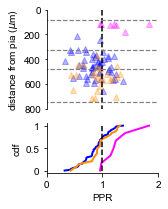

In [38]:



tick_size=2
label_size=10
fs=10
markersize=20

PPR_lim=[0,2]
pyr=full_df[(full_df.post_class=='pyramidal') & (full_df.post_layer==2)]
pyr=pyr.dropna(subset=['PPR_5t10'])
Penk_pyr=pyr[pyr.presynapticCre=='Penk']
Rorb_pyr=pyr[pyr.presynapticCre=='Rorb']
Tlx3_pyr=pyr[pyr.presynapticCre=='Tlx3']
Rorb4_pyr=Rorb_pyr[Rorb_pyr.y_pia<480]
Rorb5_pyr=Rorb_pyr[Rorb_pyr.y_pia>480]

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)

ax0.scatter(Penk_pyr.PPR_5t10, Penk_pyr.y_pia, c='magenta', marker='^',alpha=0.3)
ax0.scatter(Rorb_pyr.PPR_5t10, Rorb_pyr.y_pia, c='blue', marker='^',alpha=0.3)
ax0.scatter(Tlx3_pyr.PPR_5t10, Tlx3_pyr.y_pia, c='darkorange', marker='^',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PPR_lim)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PPR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Penk_pyr.PPR_5t10,color='magenta')
opto.plot_cdf(ax1,Rorb_pyr.PPR_5t10,color='blue')
opto.plot_cdf(ax1,Tlx3_pyr.PPR_5t10,color='darkorange')


ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1.yaxis.set_ticks([0,0.5,1])

plt.show()

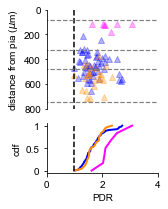

In [39]:

tick_size=2
label_size=10
fs=10
markersize=20

PDR_lim=[0,4]
pyr=standard_df[(standard_df.post_class=='pyramidal') & (standard_df.post_layer==2)]
pyr=pyr.dropna(subset=['PDR_5t10'])
Penk_pyr=pyr[pyr.presynapticCre=='Penk']
Rorb_pyr=pyr[pyr.presynapticCre=='Rorb']
Tlx3_pyr=pyr[pyr.presynapticCre=='Tlx3']
Rorb4_pyr=Rorb_pyr[Rorb_pyr.y_pia<480]
Rorb5_pyr=Rorb_pyr[Rorb_pyr.y_pia>480]

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Penk_pyr.PDR_5t10, Penk_pyr.y_pia, c='magenta', marker='^',alpha=0.3)
ax0.scatter(Rorb_pyr.PDR_5t10, Rorb_pyr.y_pia, c='blue', marker='^',alpha=0.3)
ax0.scatter(Tlx3_pyr.PDR_5t10, Tlx3_pyr.y_pia, c='darkorange', marker='^',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PDR_lim)

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PDR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Penk_pyr.PDR_5t10,color='magenta')
opto.plot_cdf(ax1,Rorb_pyr.PDR_5t10,color='blue')
opto.plot_cdf(ax1,Tlx3_pyr.PDR_5t10,color='darkorange')


ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1.yaxis.set_ticks([0,0.5,1])

plt.show()

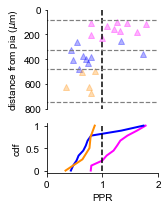

In [40]:

label_size=10
fs=10
markersize=20

PPR_lim=[0,2]
inter=full_df[(full_df.Kcluster==1) & (full_df.post_layer==2)]
inter=inter.dropna(subset=['PPR_5t10'])
Penk_inter=inter[inter.presynapticCre=='Penk']
Rorb_inter=inter[inter.presynapticCre=='Rorb']
Tlx3_inter=inter[inter.presynapticCre=='Tlx3']
Rorb4_inter=Rorb_inter[Rorb_inter.y_pia<480]
Rorb5_inter=Rorb_inter[Rorb_inter.y_pia>480]

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Penk_inter.PPR_5t10, Penk_inter.y_pia, c='magenta', marker='^',alpha=0.3)
ax0.scatter(Rorb_inter.PPR_5t10, Rorb_inter.y_pia, c='blue', marker='^',alpha=0.3)
ax0.scatter(Tlx3_inter.PPR_5t10, Tlx3_inter.y_pia, c='darkorange', marker='^',alpha=0.3)

ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PPR_lim)

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PPR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Penk_inter.PPR_5t10,color='magenta')
opto.plot_cdf(ax1,Rorb_inter.PPR_5t10,color='blue')
opto.plot_cdf(ax1,Tlx3_inter.PPR_5t10,color='darkorange')


ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1.yaxis.set_ticks([0,0.5,1])

plt.show()

m, b:  -0.20428964973996536 1.0031860984076562
(-0.3067815739108188, 0.0045346944723054575)


SpearmanrResult(correlation=-0.46358205932975605, pvalue=8.95585435808499e-06)

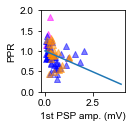

In [43]:
df_list=[Penk_pyr, Rorb_pyr, Tlx3_pyr]

colors=['magenta', 'blue', 'darkorange']
fig, ax=plt.subplots()
for df, color in zip(df_list, colors):
    ax.scatter(df.peakOfAvg, df.PPR_5t10, c=color, marker='^',alpha=0.5)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['peakOfAvg','PPR_5t10'])
m, b = np.polyfit(cat_df.peakOfAvg, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,4])
ax.plot(x,x*m+b)
#\plt.plot([0,2])
ax.set_ylim([0,2])
#ax.set_xlim([0,4])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP amp. (mV)')
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.peakOfAvg, cat_df.PPR_5t10))
stats.spearmanr(cat_df.peakOfAvg, cat_df.PPR_5t10)

m, b:  0.1538117205731165 0.7841270637567661
(0.3635280410582986, 0.07405559182708887)


SpearmanrResult(correlation=0.2561538461538462, pvalue=0.21647833224140894)

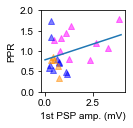

In [42]:
df_list=[Penk_inter, Rorb_inter, Tlx3_inter]

colors=['magenta', 'blue', 'darkorange']
fig, ax=plt.subplots()
for df, color in zip(df_list, colors):
    ax.scatter(df.peakOfAvg, df.PPR_5t10, c=color, marker='^',alpha=0.5)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['peakOfAvg','PPR_5t10'])
m, b = np.polyfit(cat_df.peakOfAvg, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,4])
ax.plot(x,x*m+b)
#\plt.plot([0,2])
ax.set_ylim([0,2])
#ax.set_xlim([0,4])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP amp. (mV)')
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.peakOfAvg, cat_df.PPR_5t10))
stats.spearmanr(cat_df.peakOfAvg, cat_df.PPR_5t10)

m, b:  0.029886007955857344 0.9044017050130413
(0.06279808891520205, 0.516523673160335)
SpearmanrResult(correlation=-0.28641460476322866, pvalue=0.0025335749056700162)


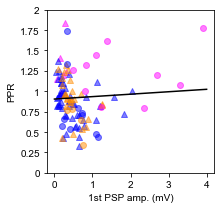

In [44]:
df_list=[Penk_pyr, Rorb_pyr, Tlx3_pyr, Penk_inter, Rorb_inter, Tlx3_inter]

colors=['magenta', 'blue', 'darkorange','magenta', 'blue', 'darkorange']
markers=['^','^','^','o','o','o']
fig, ax=plt.subplots()
for df, color, marker in zip(df_list, colors,markers):
    ax.scatter(df.peakOfAvg, df.PPR_5t10, c=color, marker=marker,alpha=0.5)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['peakOfAvg','PPR_5t10'])
m, b = np.polyfit(cat_df.peakOfAvg, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,4])
ax.plot(x,x*m+b,c='black')
#plt.plot([0,2])
ax.set_ylim([0,2])
#ax.set_xlim([0,4])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP amp. (mV)')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

fig.set_figheight(3)
fig.set_figwidth(3)
print (stats.pearsonr(cat_df.peakOfAvg, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.peakOfAvg, cat_df.PPR_5t10))
plt.show()

m, b:  0.46582915695430505 0.6550498806321732
(0.42921637515863853, 3.2089788000476446e-06)
SpearmanrResult(correlation=0.44434250764525995, pvalue=1.2975545566588366e-06)


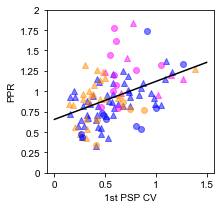

In [45]:
df_list=[Penk_pyr, Rorb_pyr, Tlx3_pyr, Penk_inter, Rorb_inter, Tlx3_inter]

colors=['magenta', 'blue', 'darkorange','magenta', 'blue', 'darkorange']
markers=['^','^','^','o','o','o']
fig, ax=plt.subplots()
for df, color, marker in zip(df_list, colors,markers):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker=marker,alpha=0.5)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,1.5])
ax.plot(x,x*m+b,c='black')

ax.set_ylim([0,2])

ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

fig.set_figheight(3)
fig.set_figwidth(3)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.CV, cat_df.PPR_5t10))
plt.show()

m, b:  0.42418323396418456 0.6815766763954375
(0.4583193620017273, 1.1649328578549558e-05)


SpearmanrResult(correlation=0.46194188518781004, pvalue=9.725214323426574e-06)

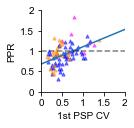

In [46]:
df_list=[Penk_pyr, Rorb_pyr, Tlx3_pyr]
#df_list=[Penk_pyr]
colors=['magenta', 'blue', 'darkorange']
fig, ax=plt.subplots()
for df, color in zip(df_list, colors):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker='^',alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b)
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,2])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
stats.spearmanr(cat_df.CV, cat_df.PPR_5t10)


m, b:  0.6805445326232571 0.5018902361480542
(0.4051482710897895, 0.04452374053767795)
SpearmanrResult(correlation=0.4746153846153846, pvalue=0.01651925246500725)


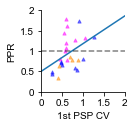

In [47]:
df_list=[Penk_inter, Rorb_inter, Tlx3_inter]

colors=['magenta', 'blue', 'darkorange']
fig, ax=plt.subplots()
for df, color in zip(df_list, colors):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker='^',alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b)
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,2])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.CV, cat_df.PPR_5t10))


m, b:  0.46582915695430505 0.6550498806321727
(0.42921637515863864, 3.208978800047612e-06)
SpearmanrResult(correlation=0.44434250764525995, pvalue=1.2975545566588366e-06)


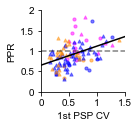

In [48]:
df_list=[Penk_inter, Rorb_inter, Tlx3_inter,Penk_pyr, Rorb_pyr, Tlx3_pyr]

colors=['magenta', 'blue', 'darkorange','magenta', 'blue', 'darkorange']
markers=['o','o','o','^','^','^']
fig, ax=plt.subplots()
for df, color,marker in zip(df_list, colors,markers):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker=marker,alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b,c='black')
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,1.5])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.CV, cat_df.PPR_5t10))


m, b:  0.029886007955856716 0.9044017050130414
(0.06279808891520201, 0.516523673160335)
SpearmanrResult(correlation=-0.28641460476322866, pvalue=0.0025335749056700162)


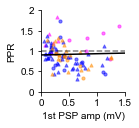

In [49]:
df_list=[Penk_inter, Rorb_inter, Tlx3_inter,Penk_pyr, Rorb_pyr, Tlx3_pyr]

colors=['magenta', 'blue', 'darkorange','magenta', 'blue', 'darkorange']
markers=['o','o','o','^','^','^']
fig, ax=plt.subplots()
for df, color,marker in zip(df_list, colors,markers):
    ax.scatter(df.peakOfAvg, df.PPR_5t10, c=color, marker=marker,alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.peakOfAvg, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b,c='black')
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,1.5])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP amp (mV)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.peakOfAvg, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.peakOfAvg, cat_df.PPR_5t10))


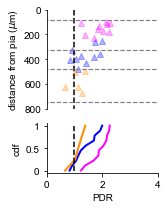

In [50]:

tick_size=2
label_size=10
fs=10
markersize=20

PDR_lim=[0,4]
inter=full_df[(full_df.Kcluster==1) & (full_df.post_layer==2)]
inter=inter.dropna(subset=['PDR_5t10'])
Penk_inter=inter[inter.presynapticCre=='Penk']
Rorb_inter=inter[inter.presynapticCre=='Rorb']
Tlx3_inter=inter[inter.presynapticCre=='Tlx3']
Rorb4_inter=Rorb_inter[Rorb_inter.y_pia<480]
Rorb5_inter=Rorb_inter[Rorb_inter.y_pia>480]

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Penk_inter.PDR_5t10, Penk_inter.y_pia, c='magenta', marker='^',alpha=0.3)
ax0.scatter(Rorb_inter.PDR_5t10, Rorb_inter.y_pia, c='blue', marker='^',alpha=0.3)
ax0.scatter(Tlx3_inter.PDR_5t10, Tlx3_inter.y_pia, c='darkorange', marker='^',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PDR_lim)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)
#ax0.set_xscale('log', basex=10)
ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PDR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Penk_inter.PDR_5t10,color='magenta')
opto.plot_cdf(ax1,Rorb_inter.PDR_5t10,color='blue')
opto.plot_cdf(ax1,Tlx3_inter.PDR_5t10,color='darkorange')


ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1.yaxis.set_ticks([0,0.5,1])
plt.show()


In [51]:


df_list=[Penk_pyr, Rorb_pyr, Tlx3_pyr, Penk_inter, Rorb_inter, Tlx3_inter]
colors=['magenta', 'darkblue','darkorange', 'pink', 'skyblue','orange' ]
cnx_classes=['Penk to PC','Rorb to PC', 'Tlx3 to PC', 'Penk to FSI', 'Rorb to FSI', 'Tlx3 to FSI']
PPR_master=[]
i=0
summary_table=np.zeros([len(cnx_classes),4])
for df,color in zip(df_list,colors):
    df=df.dropna(subset=['PPR_5t10'])
    class_name=cnx_classes[i]    
    median=np.median(df.PPR_5t10)
    mean=np.mean(df.PPR_5t10)
    sd=np.std(df.PPR_5t10)
    n=len(df.PPR_5t10)
    skew=stats.skew(df.PPR_5t10)
    print (class_name, median, mean ,sd, skew)
    summary_table[i,:]=np.array([median, mean, sd, skew])
    PPR_master.append(np.array(df.PPR_5t10))
    i+=1


Penk to PC 1.2013453884738519 1.2528571825620367 0.27727402220161995 1.040075431326663
Rorb to PC 0.8743621345902155 0.8660403411855495 0.2301223394291963 -0.16761265459698907
Tlx3 to PC 0.9117092050897229 0.9188431978563485 0.24127286386845978 -0.31155030573995157
Penk to FSI 1.2321728855986307 1.2299502898047474 0.30965475019444627 0.18102635462058847
Rorb to FSI 0.6804743045494419 0.7993553845820722 0.3949671546657078 1.4051481851084953
Tlx3 to FSI 0.7687461623768658 0.6805743597901543 0.18462778891690323 -1.0085999011974704


In [52]:
args=[l for l in PPR_master]
stats.kruskal(*args)

KruskalResult(statistic=24.574543731497783, pvalue=0.0001683154743834123)

In [53]:
def Cohens_d(pop1,pop2):
    u1=np.mean(pop1)
    u2=np.mean(pop2)
    s=np.std(np.append(pop1,pop2))
    s1=np.std(pop1)
    s2=np.std(pop2)
    d=(u2-u1)/((0.5*(s1**2+s2**2)))**0.5
    return d

In [54]:
count=len(df_list)
out_array=np.zeros([count,count])
y_array=range(count)
x_array=range(count)
i=0
for y in y_array:
    x_array=range(0,count)
    for x in x_array:
        d=Cohens_d(args[x],args[y])
        out_array[x,y]=d
    i+=1

In [55]:
import scikit_posthocs as sp
import seaborn as sns

In [56]:
out_array[out_array == 0] ='nan'
cnx_classes

['Penk to PC',
 'Rorb to PC',
 'Tlx3 to PC',
 'Penk to FSI',
 'Rorb to FSI',
 'Tlx3 to FSI']

In [57]:
exc_dunn=sp.posthoc_dunn(args,p_adjust='fdr_bh')
exc_dunn

,1,2,3,4,5,6
1,1.000000,0.007896,0.044519,0.706233,0.004128,0.004128
2,0.007896,1.000000,0.431526,0.007896,0.226986,0.137575
3,0.044519,0.431526,1.000000,0.059777,0.105194,0.074118
4,0.706233,0.007896,0.059777,1.000000,0.004128,0.004128
5,0.004128,0.226986,0.105194,0.004128,1.000000,0.616393
6,0.004128,0.137575,0.074118,0.004128,0.616393,1.000000


([<matplotlib.axis.YTick at 0x7fa59fabdbe0>,
 [Text(0, 0.5, 'Penk to PC'),
  Text(0, 1.5, 'Rorb to PC'),
  Text(0, 2.5, 'Tlx3 to PC'),
  Text(0, 3.5, 'Penk to FSI'),
  Text(0, 4.5, 'Rorb to FSI'),
  Text(0, 5.5, 'Tlx3 to FSI')])

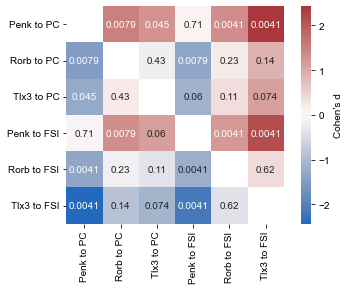

In [58]:
x_ticks=np.arange(0.5,count+0.4,1)
sns.heatmap(np.transpose(out_array),cmap='vlag',square=True, annot=exc_dunn, cbar_kws={'label': "Cohen's d"})
plt.xticks(x_ticks, cnx_classes, rotation='vertical')
plt.yticks(x_ticks, cnx_classes, rotation='horizontal')
#plt.savefig('exc_PPR_CohenDunn_table.svg')

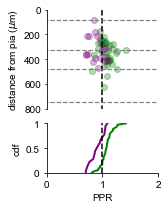

In [59]:

tick_size=2
label_size=10
fs=10
markersize=20

PPR_lim=[0,2]
df=standard_df
df=df[df.post_layer==2]
pyr=df[df.post_class=='pyramidal']
pyr=pyr.dropna(subset=['PPR_5t10'])
Sst_pyr=pyr[pyr.presynapticCre=='Sst']
Pvalb_pyr=pyr[pyr.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_pyr.PPR_5t10, Sst_pyr.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_pyr.PPR_5t10, Pvalb_pyr.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PPR_lim)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PPR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_pyr.PPR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_pyr.PPR_5t10,color='green')

ax1.set_ylim([0,1])

ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


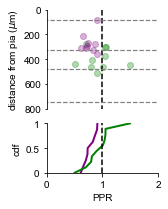

In [60]:

tick_size=2
label_size=10
fs=10
markersize=20

PPR_lim=[0,2]
df=standard_df
df=df[df.post_layer==2]
inter=df[df.Kcluster==1]
inter=inter.dropna(subset=['PPR_5t10'])
Sst_inter=inter[inter.presynapticCre=='Sst']
Pvalb_inter=inter[inter.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_inter.PPR_5t10, Sst_inter.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_inter.PPR_5t10, Pvalb_inter.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PPR_lim)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PPR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_inter.PPR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_inter.PPR_5t10,color='green')

ax1.set_ylim([0,1])

ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


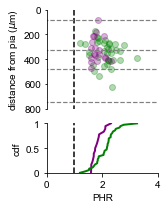

In [61]:

tick_size=2
label_size=10
fs=10
markersize=20

PDR_lim=[0,4]
df=standard_df
df=df[df.post_layer==2]
pyr=df[df.post_class=='pyramidal']
pyr=pyr.dropna(subset=['PDR_5t10'])
Sst_pyr=pyr[pyr.presynapticCre=='Sst']
Pvalb_pyr=pyr[pyr.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_pyr.PDR_5t10, Sst_pyr.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_pyr.PDR_5t10, Pvalb_pyr.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PDR_lim)
Sst_med=np.nanmedian(Sst_pyr.PDR_5t10)
Sst_mean=np.nanmean(Sst_pyr.PDR_5t10)
Pvalb_med=np.nanmedian(Pvalb_pyr.PDR_5t10)
Pvalb_mean=np.nanmean(Pvalb_pyr.PDR_5t10)


ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)
#ax0.set_xscale('log', basex=10)
ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PHR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_pyr.PDR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_pyr.PDR_5t10,color='green')

ax1.set_ylim([0,1])
#ax1.set_xlim(PDR_lim)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


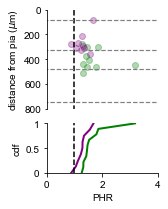

In [62]:

tick_size=2
label_size=10
fs=10
markersize=20

PDR_lim=[0,4]
df=standard_df
df=df[df.post_layer==2]
inter=df[df.Kcluster==1]
inter=inter.dropna(subset=['PDR_5t10'])
Sst_inter=inter[inter.presynapticCre=='Sst']
Pvalb_inter=inter[inter.presynapticCre=='Pvalb']

gskw = dict(height_ratios=[1,0.5], wspace=0.08)

gs = matplotlib.gridspec.GridSpec(2,1, **gskw)
mp=20
fig = plt.figure(figsize=(2,3))

ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1], sharex=ax0)
ax0.scatter(Sst_inter.PDR_5t10, Sst_inter.y_pia, c='green', marker='o',alpha=0.3)
ax0.scatter(Pvalb_inter.PDR_5t10, Pvalb_inter.y_pia, c='purple', marker='o',alpha=0.3)
ax0.plot([1,1],[0,1000],c='black', ls='dashed')
opto.layer_borders(ax0,c='grey')
ax0.set_ylim([800,0])
ax0.set_xlim(PDR_lim)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.yaxis.set_ticks_position('left')
ax0.xaxis.set_ticks_position('none')
ax0.axes.xaxis.set_visible(False)

ax0.yaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_tick_params(size=tick_size,labelsize=fs, direction='out')
ax0.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax0.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xlabel('PHR',fontsize=fs)
ax0.set_ylabel('distance from pia (' r'$\mu$'+'m)',fontsize=fs)

opto.plot_cdf(ax1,Pvalb_inter.PDR_5t10,color='purple')
opto.plot_cdf(ax1,Sst_inter.PDR_5t10,color='green')

ax1.set_ylim([0,1])
ax1.set_xlim(PDR_lim)
ax1.set_ylabel('cdf')
ax1.plot([1,1],[0,1],ls='dashed',c='black')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.show()


In [64]:

df_list=[Pvalb_pyr, Sst_pyr, Pvalb_inter, Sst_inter]
colors=['purple', 'green','purple', 'green']
cnx_classes=['Pvalb to PC','Sst to PC', 'Pvalb to FSI', 'Sst to FSI']
PPR_master=[]
i=0
summary_table=np.zeros([len(cnx_classes),4])
for df,color in zip(df_list,colors):
    df=df.dropna(subset=['PPR_5t10'])


    class_name=cnx_classes[i]
    
    median=np.median(df.PPR_5t10)
    mean=np.mean(df.PPR_5t10)
    sd=np.std(df.PPR_5t10)
    n=len(df.PPR_5t10)
    skew=stats.skew(df.PPR_5t10)

    print (class_name, median, mean ,sd, skew)

    summary_table[i,:]=np.array([median, mean, sd, skew])
    PPR_master.append(np.array(df.PPR_5t10))

    i+=1


Pvalb to PC 0.8997638203918015 0.8992404633880083 0.12499817310445467 -0.13807780077663373
Sst to PC 1.0686429529476225 1.074051286543698 0.11671808396662454 0.39890159252262164
Pvalb to FSI 0.73599944710595 0.7720786452400823 0.10305259584514187 -0.011859736594611136
Sst to FSI 0.9539735926929829 0.9373536896495478 0.2519311199038911 0.4897288625870018


In [66]:
args=[l for l in PPR_master]
print (stats.kruskal(*args))
count=len(df_list)
out_array=np.zeros([count,count])
y_array=range(count)
x_array=range(count)
i=0
for y in y_array:
    x_array=range(0,count)
    for x in x_array:
        d=Cohens_d(args[x],args[y])
        out_array[x,y]=d
    i+=1

KruskalResult(statistic=30.837203863142918, pvalue=9.198531397974321e-07)


In [67]:
out_array[out_array == 0] ='nan'
exc_dunn=sp.posthoc_dunn(args,p_adjust='fdr_bh')
exc_dunn

,1,2,3,4
1,1.000000,0.000286,0.128531,0.565806
2,0.000286,1.000000,0.000014,0.027712
3,0.128531,0.000014,1.000000,0.084712
4,0.565806,0.027712,0.084712,1.000000


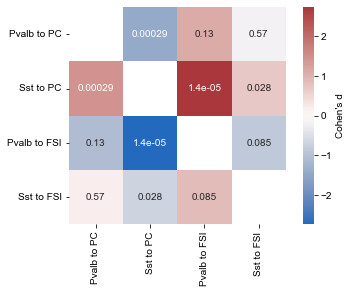

In [68]:
x_ticks=np.arange(0.5,count+0.5,1)
sns.heatmap(np.transpose(out_array),cmap='vlag',square=True, annot=exc_dunn, cbar_kws={'label': "Cohen's d"})
plt.xticks(x_ticks, cnx_classes, rotation='vertical')
plt.yticks(x_ticks, cnx_classes, rotation='horizontal')

#plt.savefig('inh_PPR_CohenDunntable.svg')

m, b:  0.22522818947216872 0.8338337844778174
(0.31101085374827286, 0.006609546422770123)
SpearmanrResult(correlation=0.35780938833570414, pvalue=0.0016231230020293818)


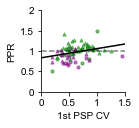

In [69]:
df_list=[Pvalb_inter, Sst_inter, Pvalb_pyr, Sst_pyr]

colors=['purple', 'green', 'purple','green']
markers=['o','o','^','^']
fig, ax=plt.subplots()
for df, color,marker in zip(df_list, colors,markers):
    ax.scatter(df.CV, df.PPR_5t10, c=color, marker=marker,alpha=0.5,s=10)
    
cat_df=pd.concat(df_list)
cat_df=cat_df.dropna(subset=['CV','PPR_5t10'])
m, b = np.polyfit(cat_df.CV, cat_df.PPR_5t10, 1)
print ("m, b: ",m,b)
x=np.array([0,2])
ax.plot(x,x*m+b,c='black')
plt.plot([0,2],[1,1],c='black',ls='dashed',alpha=0.5)
ax.set_ylim([0,2])
ax.set_xlim([0,1.5])
ax.set_ylabel('PPR')
ax.set_xlabel('1st PSP CV')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
fig.set_figheight(1.5)
fig.set_figwidth(1.5)
print (stats.pearsonr(cat_df.CV, cat_df.PPR_5t10))
print (stats.spearmanr(cat_df.CV, cat_df.PPR_5t10))
plt.show()
#plt.savefig('inh_to_all_PPRvCV.svg')